train loss:2.2961429969450005
=== epoch:1, train acc:0.12, test acc:0.121 ===
train loss:2.2895834643365958
train loss:2.2748557741446804
train loss:2.2522516569712465
train loss:2.2352022480323406
train loss:2.203025924052828
train loss:2.15852135650828
train loss:2.07897537808246
train loss:2.0833186631723613
train loss:1.9219133183660588
train loss:1.9216386950197974
train loss:1.8253114683316793
train loss:1.69812208749136
train loss:1.5862524543997045
train loss:1.5246268217442804
train loss:1.3922021262687576
train loss:1.2875602931932835
train loss:1.2844341847649523
train loss:1.2853812853092388
train loss:1.164266419685882
train loss:1.111264036563556
train loss:1.0690096625618077
train loss:1.086480067875274
train loss:0.9802404071440718
train loss:0.9849964008118275
train loss:1.0299267099238072
train loss:0.9095094826891328
train loss:0.9774035405392343
train loss:1.0040551407067326
train loss:0.9117889057140797
train loss:0.9783118400618295
train loss:0.7245118743787224
tr

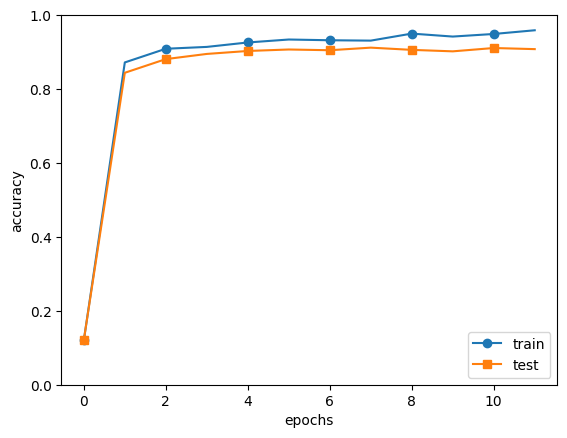

Final Train Accuracy: 0.9590
Final Test Accuracy: 0.9080


In [1]:
import sys
import os
sys.path.append(os.pardir)

import numpy as np
import matplotlib.pyplot as plt
from fashion.fashion_mnist import load_fashion_mnist
from collections import OrderedDict
from common.layers import *
from common.gradient import numerical_gradient
from common.trainer import Trainer

class SimpleConvNet:
    """
    다음과 같은 CNN을 구성한다.
    → Conv → ReLU → Pooling → Affine → ReLU → Affine → Softmax →
    """
    def __init__(self, input_dim=(1, 28, 28),
                 conv_param={'filter_num': 30, 'filter_size': 5,
                             'pad': 0, 'stride': 1},
                 hidden_size=100, output_size=10, weight_init_std=0.01):
        filter_num = conv_param['filter_num']
        filter_size = conv_param['filter_size']
        filter_pad = conv_param['pad']
        filter_stride = conv_param['stride']
        input_size = input_dim[1]
        conv_output_size = (input_size - filter_size + 2*filter_pad) / \
            filter_stride + 1
        pool_output_size = int(filter_num * (conv_output_size/2) *
                               (conv_output_size/2))

        self.params = {}
        self.params['W1'] = weight_init_std * \
            np.random.randn(filter_num, input_dim[0], filter_size, filter_size)
        self.params['b1'] = np.zeros(filter_num)
        self.params['W2'] = weight_init_std * \
            np.random.randn(pool_output_size, hidden_size)
        self.params['b2'] = np.zeros(hidden_size)
        self.params['W3'] = weight_init_std * \
            np.random.randn(hidden_size, output_size)
        self.params['b3'] = np.zeros(output_size)

        self.layers = OrderedDict()
        self.layers['Conv1'] = Convolution(self.params['W1'],
                                           self.params['b1'],
                                           conv_param['stride'],
                                           conv_param['pad'])
        self.layers['Relu1'] = Relu()
        self.layers['Pool1'] = Pooling(pool_h=2, pool_w=2, stride=2)
        self.layers['Affine1'] = Affine(self.params['W2'], self.params['b2'])
        self.layers['Relu2'] = Relu()
        self.layers['Affine2'] = Affine(self.params['W3'], self.params['b3'])
        self.last_layer = SoftmaxWithLoss()

    def predict(self, x):
        """추론을 수행"""
        for layer in self.layers.values():
            x = layer.forward(x)
        return x

    def loss(self, x, t):
        """손실함수 값 계산"""
        y = self.predict(x)
        return self.last_layer.forward(y, t)

    def accuracy(self, x, t, batch_size=100):
        if t.ndim != 1:
            t = np.argmax(t, axis=1)

        acc = 0.0

        for i in range(int(x.shape[0] / batch_size)):
            tx = x[i*batch_size:(i+1)*batch_size]
            tt = t[i*batch_size:(i+1)*batch_size]
            y = self.predict(tx)
            y = np.argmax(y, axis=1)
            acc += np.sum(y == tt)

        return acc / x.shape[0]

    def gradient(self, x, t):
        """오차역전파법으로 기울기를 구함"""
        self.loss(x, t)
        dout = 1
        dout = self.last_layer.backward(dout)

        layers = list(self.layers.values())
        layers.reverse()
        for layer in layers:
            dout = layer.backward(dout)

        grads = {}
        grads['W1'] = self.layers['Conv1'].dW
        grads['b1'] = self.layers['Conv1'].db
        grads['W2'] = self.layers['Affine1'].dW
        grads['b2'] = self.layers['Affine1'].db
        grads['W3'] = self.layers['Affine2'].dW
        grads['b3'] = self.layers['Affine2'].db

        return grads

# 데이터 읽기
(x_train, t_train), (x_test, t_test) = load_fashion_mnist(flatten=False)

max_epochs = 12

network = SimpleConvNet(input_dim=(1, 28, 28),
                        conv_param={'filter_num': 60, 'filter_size': 5, 'pad': 1, 'stride': 1},
                        hidden_size=100, output_size=10, weight_init_std=0.01)

trainer = Trainer(network, x_train, t_train, x_test, t_test,
                  epochs=max_epochs, mini_batch_size=100,
                  optimizer='Adam', optimizer_param={'lr': 0.001},
                  evaluate_sample_num_per_epoch=1000)
trainer.train()

# 그래프 그리기
markers = {'train': 'o', 'test': 's'}
x = np.arange(max_epochs)
plt.plot(x, trainer.train_acc_list, marker='o', label='train', markevery=2)
plt.plot(x, trainer.test_acc_list, marker='s', label='test', markevery=2)
plt.xlabel("epochs")
plt.ylabel("accuracy")
plt.ylim(0, 1.0)
plt.legend(loc='lower right')
plt.show()

# 최종 테스트 정확도 및 학습 정확도 출력
print(f"Final Train Accuracy: {trainer.train_acc_list[-1]:.4f}")
print(f"Final Test Accuracy: {trainer.test_acc_list[-1]:.4f}")
